In [10]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import re
import sys
import time
from typing import *
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf


##  IMPORT DATA PIPELINE PIECES

path_sdp = "/Users/usuario/git/sisepuede_data_pipeline"
if path_sdp not in sys.path:
    sys.path.append(path_sdp)

import lib.data_objects as do
import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib.data_construction_utilities as util



# Setup SISEPUEDE and SISEPUEDEDataRepository Classes

In [803]:
import sisepuede.manager.sisepuede_file_structure as sfs
importlib.reload(sc)
importlib.reload(sfs.ma.mv)
importlib.reload(sfs.ma)
importlib.reload(dc.sc)
importlib.reload(dc)

##  SISEPUEDE AND DATA PIPELINE

# get data constructs and local repository
construct = dc.SISEPUEDEDataConstructs()
repo = pu.Repository(
    {
        "local": {
            "path": "/Users/usuario/SISEPUEDE_DATA_REPOSITORY"
        }
    }
)

file_struct = construct.sisepuede_file_struct
matt = file_struct.model_attributes
regions = construct.regions
time_periods = construct.time_periods


# build some shared objs
iea_info = do.DatasetIEA(None)

##  Setup files and Inputs Reader, used to read in IEA directories

In [829]:
importlib.reload(pu)


##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("sisepuede_inputs_iran_raw.csv")
fp_data_inputs = dir_data.joinpath("sisepuede_inputs_iran.csv")
fp_data_inputs_modified = dir_data.joinpath("sisepuede_inputs_iran_modified.csv")

fp_config = dir_cur.joinpath("config_data_pipeline.yaml")
fp_cw_iea_fuel_to_ssp = pathlib.Path(file_struct.dir_ref).joinpath("data_crosswalks", "iea_fuel_categories.csv")



# get the inputs reader object
reader = pu.InputsReader(
    str(fp_config),
    sisepuede_constructs = construct,
    repository = repo,
    stop_on_error = True,
)

In [699]:



def get_electricity_generation_by_source(
    reader: pu.InputsReader,
    key_var: str = "iea_electricity_generation_by_source",
) -> pd.DataFrame:
    """
    Retrieve the Electtricity Generation by Source data frame
    """
    repo.get_path(
        reader.config.get("inputs.iea_electricity_generation_by_source.repo.path")
    )

get_regular_expressions_for_iea_csvs(
    reader,
    "inputs.iea_electricity_generation_by_source"
)
    

(re.compile(r'International Energy Agency - electricity generation sources in (.*\D).csv',
            re.UNICODE),
 re.compile(r'electricity generation sources in (.*\D$)', re.UNICODE))

In [800]:
# data functions
import data_functions_to_transfer_to_pipeline as dtmp
importlib.reload(dtmp)

<module 'data_functions_to_transfer_to_pipeline' from '/Users/usuario/git/sisepuede_region_nbs/iran/data_functions_to_transfer_to_pipeline.py'>

In [12]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

# Review fields that are missing

In [13]:
[
    x for x in df_inputs_example.columns if x not in df_inputs_raw.columns
]

['region',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_water',
 'strategy_id',
 'cost_enfu_fuel_ammonia_usd_per_tonne',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia',
 'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia',
 'exports_enfu_pj_fuel_ammonia',
 'frac_enfu_fuel_demand_imported_pj_fuel_ammonia',
 'nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw',
 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj',
 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2',
 'nemomod_entc_fixed_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_fixed_cost_fp_hydrogen_refo

###   Build the file here

- Drop unecessary fields
- Use systematic keys/index fields
- add region name

In [14]:
##  SOME MANUAL FIXES FOR THE MOMENT

df_inputs_example["exports_enfu_pj_fuel_ammonia"] = 0


fields_drop_example = [
    x for x in [regions.key, matt.dim_strategy_id]
    if x in df_inputs_example
]

fields_drop_raw = [
    x for x in ["iso_code3", "Year"]
    if x in df_inputs_example
]

df_inputs = sf.match_df_to_target_df(
    df_inputs_example
    .drop(
        columns = fields_drop_example,
    ),
    df_inputs_raw
    .drop(
        columns = fields_drop_raw,
    ),
    [time_periods.field_time_period],
    overwrite_only = False,
)

df_inputs[regions.key] = "iran"

# Some needed models

In [ ]:
# PULL IN MODELS w/O ELECTRICITY
import sisepuede.manager.sisepuede_models as sm
models_noelec = sm.SISEPUEDEModels(
    matt,
    allow_electricity_run = False,
    initialize_julia = False,
)

model_enercons = models_noelec.model_enercons
model_enercons.modvar_dict_scoe_fuel_fractions_to_efficiency_factors


# run model w/o fuel production
df_out_base = models_noelec.project(
    df_inputs
)



# Load datasets
- These can be moved to an `InputsReader` object

##  Build some dictionaries that we need

In [597]:
df_cw_to_dict

,iea_fuels,``$CAT-FUEL$``
1,Biofuels,``fuel_biofuels``
5,Coal,``fuel_coal``
8,Diesel,``fuel_diesel``
9,Electricity,``fuel_electricity``
17,Natural Gas,``fuel_natural_gas``
18,Natural gas,``fuel_natural_gas``
19,Nuclear,``fuel_nuclear``
21,Oil,``fuel_oil``
23,Solar,``fuel_solar``
24,Solar PV,``fuel_solar``


In [925]:

######
#    SOME DICTIONARIES    #
##

def get_iea_fuel_to_entc_pp_dicts(
    model_attributes: 'ModelAttributes',
    attribute_field_fuel: str = "electricity_generation_cat_fuel",
    flag_ccs: str = "_ccs",
) -> Tuple[dict, dict]:
    """
    Retrieve dictionaries mapping 

        1. ENTC power plant categories to fuels
        2. ENFU categories to applicable techs for allocation from
            IEA data. NOTE: excludes ccs

    Function Arguments
    ------------------
    - model_attributes: model attributes object
    
    Keyword Arguments
    -----------------
    - attribute_field_fuel: field in the technology attribute table
        storing the fuel used by entc 
    - flag_ccs: flag in ENTC categories used to denote CCS
    """
    # retrieve attribute tables
    attr_enfu = model_attributes.get_attribute_table(
        model_attributes.subsec_name_enfu, 
    )
    attr_entc = model_attributes.get_attribute_table(
        model_attributes.subsec_name_entc, 
    )
    
    dict_entc_cat_to_fuel = dict(
        (
            x, 
            sfs.ma.clean_schema(
                attr.get_attribute(x, attribute_field_fuel)
            )
        )
        for x in attr.key_values
    )

    # get the dictionary mapping ENTC power plants to fueld
    dict_entc_pp_cat_to_enfu_cat = dict(
        (k, v) for k, v in dict_entc_cat_to_fuel.items() 
        if v in attr_enfu.key_values
    )

    # reverse it and drop ccs from our IEA allocation for now
    dict_enfu_cat_to_entc_pp_cat = sf.reverse_dict(
        dict_entc_pp_cat_to_enfu_cat,
        allow_multi_keys = True,
        force_list_values = True,
    )
    dict_enfu_cat_to_entc_pp_cat = dict(
        (k, [x for x in v if flag_ccs not in v][0]) 
        for k, v in dict_enfu_cat_to_entc_pp_cat.items()
        
    )
    
    out = (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat,
    )

    return out


# get the crosswalk mapping IEA techs to SISEPUEDE techs

def build_dictionaries_iea_to_ssp(
    df_cw: pd.DataFrame,
    model_attributes: 'ModelAttributes',
    **kwargs,
) -> Tuple[dict]:
    """
    Build dictionaries used in crosswalks. Builds the following 
        dictionaries (in order of output tuple):

        * dict_iea_fuel_to_enfu_cat
        * dict_entc_pp_cat_to_enfu_cat
        * dict_enfu_cat_to_entc_pp_cat

    Function Arguments
    ------------------
    - model_attributes: model attributes object
    
    Keyword Arguments
    -----------------
    - **kwargs: passed to get_iea_fuel_to_entc_pp_dicts
    """

    # get dicitionary mapping fuels to ENTC power plants
    (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat
    ) = get_iea_fuel_to_entc_pp_dicts(
        model_attributes,
        **kwargs,
    )

    pycatdisp_enfu = matt.get_subsector_attribute(
        model_attributes.subsec_name_enfu, 
        "primary_category",
    )
    
    # unwrap the dataframe to get IEA -> SSP 
    fields_ord = ["iea_fuels", "``$CAT-FUEL$``"]
    df_cw_to_dict = (
        sf.unwrap_df_from_delimiter(
            df_cw[fields_ord],
            "iea_fuels"
        )
        .dropna()
        .get(fields_ord)
    )

    # map 
    dict_iea_fuel_to_enfu_cat = sf.build_dict(df_cw_to_dict, )

    # clean the fields
    dict_iea_fuel_to_enfu_cat = dict(
        (k, sfs.ma.clean_schema(v)) 
        for k, v in dict_iea_fuel_to_enfu_cat.items()
    )

    dict_iea_fuel_to_entc_cat = dict(
        (k, dict_enfu_cat_to_entc_pp_cat.get(v))
        for k, v in dict_iea_fuel_to_enfu_cat.items() 
    )

    dict_iea_fuel_to_entc_cat = dict(
        (k, v) for k, v in dict_iea_fuel_to_entc_cat.items()
        if v is not None
    )

    # return dicts
    out = (
        dict_entc_pp_cat_to_enfu_cat,
        dict_enfu_cat_to_entc_pp_cat,
        dict_iea_fuel_to_enfu_cat,
        dict_iea_fuel_to_entc_cat,
    )

    return out


df_cw = pd.read_csv(fp_cw_iea_fuel_to_ssp)
(
    dict_entc_pp_cat_to_enfu_cat,
    dict_enfu_cat_to_entc_pp_cat,
    dict_iea_fuel_to_enfu_cat,
    dict_iea_fuel_to_entc_cat,
) = build_dictionaries_iea_to_ssp(
    df_cw,
    matt,
)

In [931]:
dtmp.select_iea_groups_by_fuel(
    df_scoe_consumption_res,
    df_cw,
    matt,
)

{'fuel_biofuels': 'Biofuels and waste',
 'fuel_coal': 'Coal',
 'fuel_electricity': 'Electricity',
 'fuel_natural_gas': 'Natural gas',
 'fuel_solar': 'Wind, solar, etc.',
 'fuel_waste': 'Biofuels and waste',
 'fuel_wind': 'Wind, solar, etc.'}

# Build Some Functions
- MinShareProduction: "electricity generation sources"

###  Industrial Consumption

In [951]:
importlib.reload(dtmp)
modvar_inen_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_inen
)


df_inen_consumption = dtmp.combine_iea_csvs_to_table(
    reader,
    construct,
    "iea_total_consumption_by_source_ind",
    fillval = 0.0,
)  

df_inen_consumption = dtmp.aggregate_and_pivot_iea_fuel(
    df_inen_consumption,
    reader.get_input("iea_total_consumption_by_source_ind.field_iea_index_renamed"),
    modvar_inen_energy_demand,
    construct,
    iea_info,
    convert_units = True,
    dict_cat_repl = dict_iea_fuel_to_enfu_cat,
) 





###  Get Observed Consumption by Sector

In [952]:
##  INDUSTRY

modvar_inen_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_inen
)
df_inen_consumption = dtmp.get_wide_iea_data_in_variable_units(
    reader,
    construct,
    "iea_total_consumption_by_source_ind",
    modvar_inen_energy_demand,
    iea_info,
)



##  SCOE - COMMERCIAL AND PUBLIC SERVICES

modvar_scoe_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_scoe
)
df_scoe_consumption_cps = dtmp.get_wide_iea_data_in_variable_units(
    reader,
    construct,
    "iea_total_consumption_by_source_cps",
    modvar_scoe_energy_demand,
    iea_info,
)



##  SCOE - RESIDENTIAL

df_scoe_consumption_res = dtmp.get_wide_iea_data_in_variable_units(
    reader,
    construct,
    "iea_total_consumption_by_source_res",
    modvar_scoe_energy_demand,
    iea_info,
)



##  TRANSPORTATION

modvar_trns_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_trns
)
df_trns_consumption = dtmp.get_wide_iea_data_in_variable_units(
    reader,
    construct,
    "iea_total_consumption_by_source_trn",
    modvar_trns_energy_demand,
    iea_info,
)

In [988]:
[x for x in df_outputs.columns if "house" in x]
num_households = df_outputs["qty_gnrl_households"].iloc[0]

#matt.extract_model_variable(
#    df_inputs,
#    model_enercons.modvar_scoe_efficiency_fact_heat_en_coal,
#)

total_scoe_base = matt.extract_model_variable(
    df_outputs,
    modvar_scoe_energy_demand,
).sum(axis = 1).iloc[0]



In [1035]:
#[x for x in dir(model_enercons) if x.startswith("modvar_scoe")]

In [1105]:
(
    matt
    .extract_model_variable(
        df_inputs,
        model_enercons.modvar_scoe_consumpinit_energy_per_mmmgdp_elec
    )  
);

In [1094]:
elec_consump_per_hh = float(
    matt
    .extract_model_variable(
        df_inputs,
        model_enercons.modvar_scoe_consumpinit_energy_per_hh_elec
    )
    .iloc[0]
)

elec_consump_per_gdp = float(
    matt
    .extract_model_variable(
        df_inputs,
        model_enercons.modvar_scoe_consumpinit_energy_per_mmmgdp_elec
    )
    .iloc[0, 0]
)

heat_consump_per_hh = float(
    matt
    .extract_model_variable(
        df_inputs,
        model_enercons.modvar_scoe_consumpinit_energy_per_hh_heat
    )
    .iloc[0]
)

heat_consump_per_gdp = float(
    matt
    .extract_model_variable(
        df_inputs,
        model_enercons.modvar_scoe_consumpinit_energy_per_mmmgdp_heat
    )
    .iloc[0, 0]
)

hh = float(
    matt
    .extract_model_variable(
        df_outputs,
        "Number of Households",
    )
    .iloc[0]
)

gdp = float(
    matt.extract_model_variable(
        df_inputs,
        "GDP"
    )
    .iloc[0]
)

#heat_consump_per_hh
init_cons_ssp_res = (elec_consump_per_hh + heat_consump_per_hh)*hh/1000000 
init_cons_ssp_cps = (elec_consump_per_gdp + heat_consump_per_gdp)*gdp/1000



###  GET IEA NUMS

df_cps_fuels_only = (
    df_scoe_consumption_cps[
        df_scoe_consumption_cps[regions.field_iso].isin(["IRN"])
    ]
    .drop(columns = [regions.field_iso, time_periods.field_time_period])
)

df_res_fuels_only = (
    df_scoe_consumption_res[
        df_scoe_consumption_res[regions.field_iso].isin(["IRN"])
    ]
    .drop(columns = [regions.field_iso, time_periods.field_time_period])
)

##  TOTALS
total_cps_iea = (
    df_cps_fuels_only
    .sum(axis = 1)
    .iloc[0]
)

total_res_iea = (
    df_res_fuels_only
    .sum(axis = 1)
    .iloc[0]
)



In [1107]:
[x for x in df_inputs.columns if ("frac_scoe" in x) and ("electricity" in x)]
df_inputs["frac_scoe_heat_energy_commercial_municipal_electricity"]


['frac_scoe_heat_energy_commercial_municipal_electricity',
 'frac_scoe_heat_energy_other_se_electricity',
 'frac_scoe_heat_energy_residential_electricity']

In [1037]:
scalar_cps = total_cps_iea/init_cons_ssp_cps
scalar_res = total_res_iea/init_cons_ssp_res

In [1056]:
def norm_df(
    df: pd.DataFrame,
) -> pd.DataFrame:

    cols = df.columns
    arr = sf.do_array_mult(
        df.to_numpy(),
        1/df.sum(axis = 1).to_numpy()
    )

    out = pd.DataFrame(arr, columns = cols)

    return out


norm_df(df_cps_fuels_only).iloc[0], " ", " ", norm_df(df_res_fuels_only).iloc[0]

(Biofuels and waste    0.022789
 Coal                  0.000000
 Electricity           0.306895
 Heat                  0.000000
 Natural gas           0.539053
 Oil products          0.131263
 Wind, solar, etc.     0.000000
 Name: 0, dtype: float64,
 ' ',
 ' ',
 Biofuels and waste    0.004950
 Coal                  0.000169
 Electricity           0.128595
 Heat                  0.000000
 Natural gas           0.774301
 Oil products          0.091984
 Wind, solar, etc.     0.000000
 Name: 0, dtype: float64)

# try to rebalance

In [1148]:
#scalar_scoe_totals = (total_res_iea + total_cps_iea)/total_scoe_base
df_inputs_new = df_inputs.copy()
flds = []




## RESCALARS FOR GDP

elec_consumpinit_new_cps = df_cps_fuels_only["Electricity"].iloc[0]/2
heat_consumpinit_new_cps = df_cps_fuels_only.sum(axis = 1).iloc[0] - df_cps_fuels_only["Electricity"].iloc[0]/2

#init_cons_ssp_res = (elec_consump_per_hh + heat_consump_per_hh)*hh/1000000 
init_cons_elec_ssp_cps = elec_consump_per_gdp*gdp/1000
fld = "consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_elec_appliances"
flds.append(fld)
df_inputs_new[fld] = df_inputs_new[fld].to_numpy()*(elec_consumpinit_new_cps/init_cons_elec_ssp_cps)

init_cons_heat_ssp_cps = heat_consump_per_gdp*gdp/1000
fld = "consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_heat_energy"
flds.append(fld)
df_inputs_new[fld] = df_inputs_new[fld].to_numpy()*(heat_consumpinit_new_cps/init_cons_heat_ssp_cps)




## RESCALARS FOR HH

elec_consumpinit_new_res = df_res_fuels_only["Electricity"].iloc[0]/2
heat_consumpinit_new_res = df_res_fuels_only.sum(axis = 1).iloc[0] - df_res_fuels_only["Electricity"].iloc[0]/2

#init_cons_ssp_res = (elec_consump_per_hh + heat_consump_per_hh)*hh/1000000 
init_cons_elec_ssp_res = elec_consump_per_hh*hh/1000000
fld = "consumpinit_scoe_gj_per_hh_residential_elec_appliances"
flds.append(fld)
df_inputs_new[fld] = df_inputs_new[fld].to_numpy()*(elec_consumpinit_new_res/init_cons_elec_ssp_res)

init_cons_heat_ssp_res = heat_consump_per_hh*hh/1000000
fld = "consumpinit_scoe_gj_per_hh_residential_heat_energy"
flds.append(fld)
df_inputs_new[fld] = df_inputs_new[fld].to_numpy()*(heat_consumpinit_new_res/init_cons_heat_ssp_res)


##  NEXT, JUST ASSIGN BIOFUEL FRACTIONS TO NATURAL GAS

# new natural gas fraction commercial and public services
frac_diesel = 0.8
vec_diesel_cps = np.array(df_inputs_new["frac_scoe_heat_energy_commercial_municipal_diesel"].copy())
frac_natural_gas_cps = np.array(df_inputs_new["frac_scoe_heat_energy_commercial_municipal_natural_gas"])
frac_natural_gas_cps += np.array(df_inputs_new["frac_scoe_heat_energy_commercial_municipal_solid_biomass"])
frac_natural_gas_cps += vec_diesel_cps*frac_diesel
df_inputs_new["frac_scoe_heat_energy_commercial_municipal_natural_gas"] = frac_natural_gas_cps
df_inputs_new["frac_scoe_heat_energy_commercial_municipal_solid_biomass"] = 0
df_inputs_new["frac_scoe_heat_energy_commercial_municipal_diesel"] = (1 - frac_diesel)*vec_diesel_cps


# new natural gas fraction residential
vec_diesel_res = np.array(df_inputs_new["frac_scoe_heat_energy_residential_diesel"].copy())
frac_natural_gas_res = np.array(df_inputs_new["frac_scoe_heat_energy_residential_natural_gas"])
frac_natural_gas_res += np.array(df_inputs_new["frac_scoe_heat_energy_residential_solid_biomass"])
frac_natural_gas_res += vec_diesel_res*frac_diesel
df_inputs_new["frac_scoe_heat_energy_residential_natural_gas"] = frac_natural_gas_res
df_inputs_new["frac_scoe_heat_energy_residential_solid_biomass"] = 0
df_inputs_new["frac_scoe_heat_energy_residential_diesel"] = (1 - frac_diesel)*vec_diesel_res

In [1204]:
df_inputs_new["consumpinit_scoe_gj_per_hh_residential_elec_appliances"]

0     6.980494
1     6.980494
2     6.980494
3     6.980494
4     6.980494
5     6.980494
6     6.980494
7     6.980494
8     6.980494
9     6.980494
10    6.980494
11    6.980494
12    6.980494
13    6.980494
14    6.980494
15    6.980494
16    6.980494
17    6.980494
18    6.980494
19    6.980494
20    6.980494
21    6.980494
22    6.980494
23    6.980494
24    6.980494
25    6.980494
26    6.980494
27    6.980494
28    6.980494
29    6.980494
30    6.980494
31    6.980494
32    6.980494
33    6.980494
34    6.980494
35    6.980494
Name: consumpinit_scoe_gj_per_hh_residential_elec_appliances, dtype: float64

In [1160]:
importlib.reload(dtmp)
def build_msp(
    df: pd.DataFrame,
    dict_tech_repl: dict,
    construct: dc.SISEPUEDEDataConstructs,
    dataset_iea: do.DatasetIEA,
    input_dataset: str = "iea_electricity_generation_by_source",
    key_dict: str = "electricity generation sources",
    key_field_iea_index: str = "field_iea_index_renamed",
    modvar: Union[str, 'ModelVariable'] = "NemoMod MinShareProduction",
) -> pd.DataFrame:
    """
    """

    model_attributes = construct.sisepuede_file_struct.model_attributes
    
    # categories to keep
    cats_keep = model_attributes.filter_keys_by_attribute(
        model_attributes.subsec_name_entc,
        {
            "power_plant": 1
        }
    )

    df_msp = dtmp.combine_iea_csvs_to_table(
        reader,
        construct,
        input_dataset,
        fillval = 0.0,
    )  
    
    df_msp = dtmp.aggregate_and_pivot_iea_fuel(
        df_msp,
        reader.get_input(f"{input_dataset}.{key_field_iea_index}"),
        modvar,
        construct,
        dataset_iea,
        calculate_proportion = True,
        cats_keep = cats_keep,
        dict_cat_repl = dict_tech_repl, #dict_iea_fuel_to_enfu_cat,
        time_periods_type = "all",
    ) 

    """
    df_out = aggregate_and_pivot_iea_fuel_single_region(
        dict_files,
        key_dict,# = "electricity generation sources",
        modvar,# = "NemoMod MinShareProduction",
        model_attributes,
        time_periods,
        regions,
        calculate_proportion = True,
        cats_keep = cats_keep,
        dataset_iea = dataset_iea,
        dict_cat_repl = dict_tech_repl,
        field_tech = field_tech,
    )
    """;

    return df_msp



df_msp = build_msp(
    dict_files,
    dict_iea_fuel_to_entc_cat,
    construct,
    iea_info,
)




In [1162]:
df_msp_iran = (
    df_msp[
        df_msp[regions.field_iso].isin(["IRN"])
    ]
    .drop(columns = [regions.field_iso])
    .reset_index(drop = True, )
)

df_inputs_new = sf.match_df_to_target_df(
    df_inputs_new,
    df_msp_iran,
    [time_periods.field_time_period],
    overwrite_only = False,
)

###  ADD IN RICE 

In [ ]:
[x for x in df_outputs_new.columns if "rice" in x]

#df_inputs_new["frac_agrc_initial_area_cropland_rice"]
df_inputs_new["yf_agrc_rice_tonne_ha"] = float(df_inputs_new["yf_agrc_rice_tonne_ha"].iloc[7])


0    2586.542000
1    2605.840034
2    2626.941976
3    2644.888316
4    2659.022330
dtype: float64


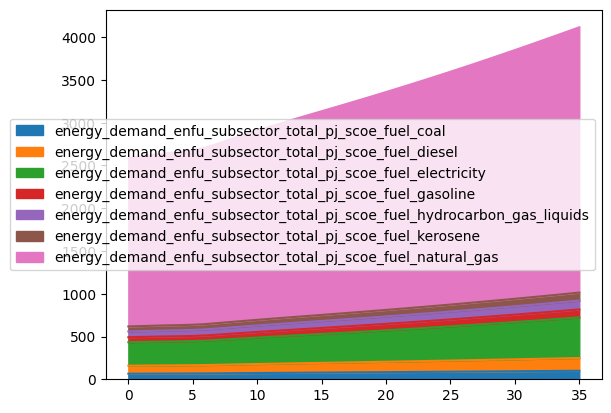

In [1164]:
df_outputs_new = models_noelec.project(df_inputs_new)

df = matt.extract_model_variable(
    df_outputs_new,
    modvar_scoe_energy_demand,
)
fields_drop = [x for x in df.columns if df[x].max() == 0.0]

(
    df
    .drop(columns = fields_drop)
    .plot
    .area()
)

print(df.sum(axis = 1).head())

In [1202]:
df_inputs_new.to_csv(
    fp_data_inputs_modified,
    index = None,
    encoding = "UTF-8",
)

PosixPath('/Users/usuario/git/sisepuede_region_nbs/iran/data/sisepuede_inputs_iran_modified.csv')

<Axes: xlabel='time_period'>

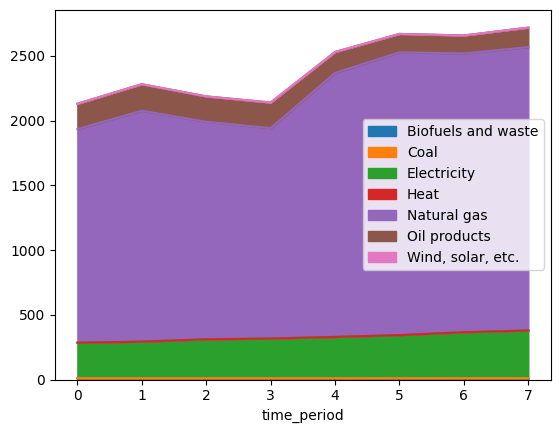

In [1140]:
df_scoe_consumption_res[
    df_scoe_consumption_res[regions.field_iso].isin(["IRN"])
].plot.area(x = "time_period")




<Axes: xlabel='time_period'>

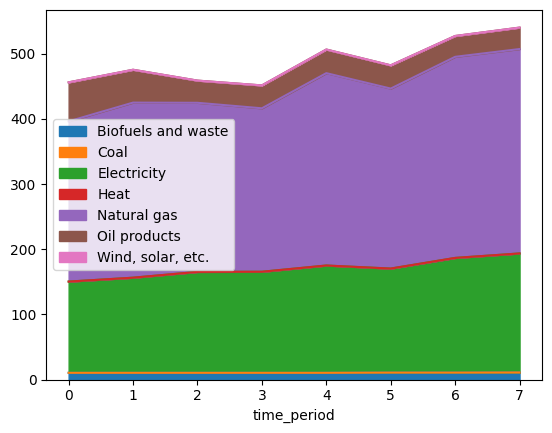

In [1124]:
df_scoe_consumption_cps[
    df_scoe_consumption_cps[regions.field_iso].isin(["IRN"])
].plot.area(x = "time_period")

<Axes: xlabel='time_period'>

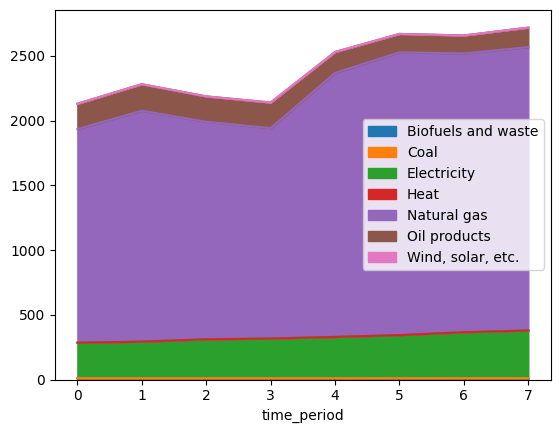

In [1123]:
df_scoe_consumption_res[
    df_scoe_consumption_res[regions.field_iso].isin(["IRN"])
].plot.area(x = "time_period")

0    4990.425617
1    4993.290560
2    4995.781858
3    4991.205328
4    4982.771952
dtype: float64


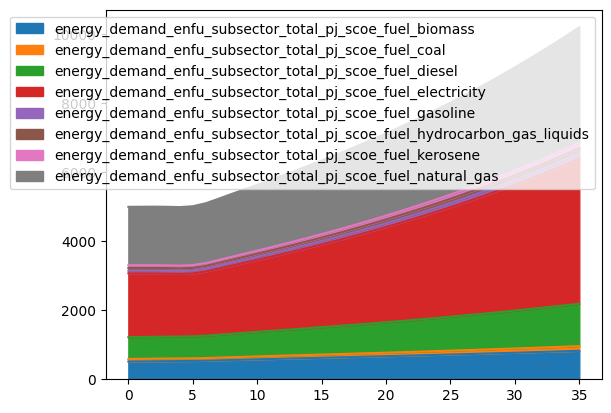

In [606]:
df = matt.extract_model_variable(
    df_outputs,
    modvar_scoe_energy_demand,
)
fields_drop = [x for x in df.columns if df[x].max() == 0.0]

(
    df
    .drop(columns = fields_drop)
    .plot
    .area()
)

print(df.sum(axis = 1).head())

# DO SOME QUICK AND DIRTY REBALANCING

# Build Rescaling to Match 

In [954]:
modvar_scoe_energy_demand = matt.get_variable(
    models_noelec
    .model_enercons
    .modvar_enfu_energy_demand_by_fuel_scoe
)

def rescale_scoe_to_iea(
    df_inputs: pd.DataFrame,
    df_scoe_consumption_cps: pd.DataFrame,
    df_scoe_consumption_res: pd.DataFrame,
    df_cw: pd.DataFrame,
    model_enercons: 'EnergyConsumption',
    modvar_demand: Union[str, sfs.ma.mv.ModelVariable] = "Energy Demand by Fuel in SCOE",
    df_outputs: Union[pd.DataFrame, None] = None,
) -> pd.DataFrame:
    """
    Rescale some inputs to SSP to better match outputs in df_scoe_consumption
    """

    ##  SOME INITIALIZATION

    matt = model_enercons.model_attributes
    modvar_demand = matt.get_variable(modvar_demand, )
    
    # retrieve fuel/variable dictionaries
    (
        dict_cat_enfu_to_scoe_heat_fuel_fraction,
        dict_cat_enfu_to_scoe_heat_fuel_efficiency,
    ) = dtmp.get_dict_enfu_cat_to_scoe_vars(
        model_enercons, 
    )

    # get the dictionary mapping fuel categories to IEA fields for aggregation
    dict_cat_enfu_to_iea_field = dtmp.select_iea_groups_by_fuel(
        df_scoe_consumption,
        df_cw,
        matt,
    )

    if not isinstance(df_outputs, pd.DataFrame):
        df_outputs = model_enercons(df_inputs, )


    # get total SCOE modeled
    
    

    

    

    return dict_cat_enfu_to_iea_field





rescale_scoe_to_iea(
    df_inputs,
    df_scoe_consumption_res[
        df_scoe_consumption_res[regions.field_iso].isin(["IRN"])
    ],
    df_cw,
    model_enercons,
)   


{'fuel_biofuels': 'Biofuels and waste',
 'fuel_coal': 'Coal',
 'fuel_electricity': 'Electricity',
 'fuel_natural_gas': 'Natural gas',
 'fuel_solar': 'Wind, solar, etc.',
 'fuel_waste': 'Biofuels and waste',
 'fuel_wind': 'Wind, solar, etc.'}

In [950]:
def get_consumption_total(
    df_consumption: pd.DataFrame,
    constructs: dc.SISEPUEDEDataConstructs,
    field_total: str = "total",
) -> np.ndarray:

    fields_drop = [
        constructs.regions.field_iso,
        constructs.time_periods.field_time_period
    ]
    
    out = (
        (
            df_consumption
            .drop(columns = fields_drop)
            .sum(axis = 1)
        )
        .to_numpy()
    )

    return out

get_consumption_total(
    df_scoe_consumption_res,
    construct,
)



array([  50.294,   53.015,   55.946,   51.382,   54.452,   58.954,
         63.123,   65.965,   65.965,   65.965,   65.965,   65.965,
         65.965,   65.965,   65.965,   65.965,   65.965,   65.965,
         65.965,   65.965,   65.965,   65.965,   65.965,   65.965,
         65.965,   65.965,   65.965,   65.965,   65.965,   65.965,
         65.965,   65.965,   65.965,   65.965,   65.965,   65.965,
       2130.526, 2281.369, 2187.415, 2139.894, 2530.2  , 2670.022,
       2657.802, 2718.698, 2718.698, 2718.698, 2718.698, 2718.698,
       2718.698, 2718.698, 2718.698, 2718.698, 2718.698, 2718.698,
       2718.698, 2718.698, 2718.698, 2718.698, 2718.698, 2718.698,
       2718.698, 2718.698, 2718.698, 2718.698, 2718.698, 2718.698,
       2718.698, 2718.698, 2718.698, 2718.698, 2718.698, 2718.698])

In [946]:
(
    dict_cat_enfu_to_scoe_heat_fuel_fraction,
    dict_cat_enfu_to_scoe_heat_fuel_efficiency,
) = dtmp.get_dict_enfu_cat_to_scoe_vars(
    model_enercons, 
)

dict_cat_enfu_to_scoe_heat_fuel_fraction.get("fuel_diesel").fields


['frac_scoe_heat_energy_commercial_municipal_diesel',
 'frac_scoe_heat_energy_other_se_diesel',
 'frac_scoe_heat_energy_residential_diesel']

In [622]:
pycatdisp_enfu = matt.get_subsector_attribute(
    matt.subsec_name_enfu, 
    "pycategory_primary_element",
)
pycatdisp_enfu


'cat_fuel'

# write to inputs

In [20]:
(
    df_inputs
    .to_csv(
        fp_data_inputs,
        index = None,
        encoding = "UTF-8",
    )
)

# Next, pull in outputs generated from running SISEPUEDE before scaling inputs
- we'll use this to scale IEA

In [25]:
df_out_raw = pd.read_csv(
    dir_data.joinpath("sisepuede_outputs_iran_preiea.csv")
)

key = matt.dim_primary_id
df_out_raw = (
    df_out_raw[
        df_out_raw[key].isin([0])
    ]
    .reset_index(drop = True, )
    .drop(columns = [key])
)

# Read in IEA datasets
- start building a generalizable set of functions to use for integrating IEA datasets from country profiles

In [172]:
#[x for x in matt.all_variables if ("Consumption" in x)]

In [171]:
vec_gdp = matt.extract_model_variable(
    df_inputs,
    "GDP",# "Land Use Area",
    return_type = "array_base"
)

vec_num_hh = matt.extract_model_variable(
    df_out_raw,
    "Number of Households",# "Land Use Area",
    return_type = "array_base"
)

vec_appliance_demand_per_hh = matt.extract_model_variable(
    df_inputs,
    "SCOE Initial Per Household Electric Appliances Energy Consumption",
    return_type = "array_base",
)

vec_heat_demand_per_hh = matt.extract_model_variable(
    df_inputs,
    "SCOE Initial Per Household Heat Energy Consumption",
    return_type = "array_base",
)

"""
matt.get_variable_characteristic(
    "SCOE Initial Per Household Electric Appliances Energy Consumption",
    "unit_energy"
)
"""
# in pj
vec_appliance_demand_res = vec_appliance_demand_per_hh*vec_num_hh/10**6
vec_heat_demand_res = vec_heat_demand_per_hh*vec_num_hh/10**6

In [189]:
vec_heat_demand_per_hh
vec_appliance_demand_per_hh


array([ 84.9097254 ,  84.46722356,  84.02472405,  83.58222384,
        83.13972392,  83.27804558,  83.84806242,  84.41808684,
        84.98811866,  85.5581577 ,  88.08300372,  90.75350048,
        93.42385872,  96.09407616,  98.76416421, 101.73120343,
       104.79724502, 107.86318038, 110.92901094, 113.9947381 ,
       117.28422666, 120.64998857, 124.01566787, 127.38126547,
       130.74678229, 133.8865539 , 137.16058022, 140.43456465,
       143.70850751, 146.98240915, 149.85046572, 152.9283556 ,
       156.0062367 , 159.08410906, 158.88904297, 158.69445466])

In [ ]:
df_inputs.to_csv(
    fp_data_inputs_modified,
    index = None,
    encoding = "UTF-8"
)

In [198]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["costa_rica"],
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-05 00:54:45,039 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-05 00:54:45,039 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-05 00:54:45,041 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-05 00:54:45,041 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-05 00:54:45,042 - INFO - 	Setting export engine to 'csv'.
2024-11-05 00:54:45,042 - INFO - 	Setting export engine to 'csv'.
2024-11-05 00:54:45,043 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-05 00:54:45,043 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-05 00:54:45,043 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-11-05 00:54:45,043 - INFO - Successfully

[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Using Julia 1.11.1 at /Users/usuario/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/bin/julia
[juliapkg] Using Julia project at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="Cbc", uuid="9961bab8-2fa3-5c5a-9d89-47fab24efd76"), Pkg.PackageSpec(name="Clp", uuid="e2554f3b-3117-50c0-817c

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.11.0
  [b6b21f68] + Ipopt v1.6.7
  [4076af6c] + JuMP v1.23.3
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
⌅ [6099a3de] + PythonCall v0.9.22
  [0aa819cd] + SQLite v1.6.1
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.23
  [88353bc9] + ConfParser v0.1.2
  [a8cc5b0e] + Crayons v4.1.1
  

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1259.5 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-05 00:55:28,152 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-05 00:55:28,152 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-05 00:55:28,165 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-05 00:55:28,165 - INFO - Succ

In [1166]:
df_outputs_new = ssp.models.project(df_inputs_new)

2024-11-11 03:41:00,439 - INFO - Running AFOLU model
2024-11-11 03:41:00,439 - INFO - Running AFOLU model
2024-11-11 03:41:00,567 - INFO - AFOLU model run successfully completed
2024-11-11 03:41:00,567 - INFO - AFOLU model run successfully completed
2024-11-11 03:41:00,568 - INFO - Running CircularEconomy model
2024-11-11 03:41:00,568 - INFO - Running CircularEconomy model
2024-11-11 03:41:00,595 - INFO - CircularEconomy model run successfully completed
2024-11-11 03:41:00,595 - INFO - CircularEconomy model run successfully completed
2024-11-11 03:41:00,595 - INFO - Running IPPU model
2024-11-11 03:41:00,595 - INFO - Running IPPU model
2024-11-11 03:41:00,638 - INFO - IPPU model run successfully completed
2024-11-11 03:41:00,638 - INFO - IPPU model run successfully completed
2024-11-11 03:41:00,638 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-11 03:41:00,638 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-11 0

2024-11-Nov 03:41:01.876 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-11 03:41:33,015 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-11 03:41:33,015 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-11 03:41:33,022 - INFO - EnergyProduction model run successfully completed
2024-11-11 03:41:33,022 - INFO - EnergyProduction model run successfully completed
2024-11-11 03:41:33,022 - INFO - Running Energy (Fugitive Emissions)
2024-11-11 03:41:33,022 - INFO - Running Energy (Fugitive Emissions)
2024-11-11 03:41:33,044 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-11 03:41:33,044 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-11 03:41:33,045 - INFO - Appending Socioeconomic outputs
2024-11-11 03:41:33,045 - INFO - Appending Socioec

2024-11-Nov 03:41:32.934 Finished modeling scenario.


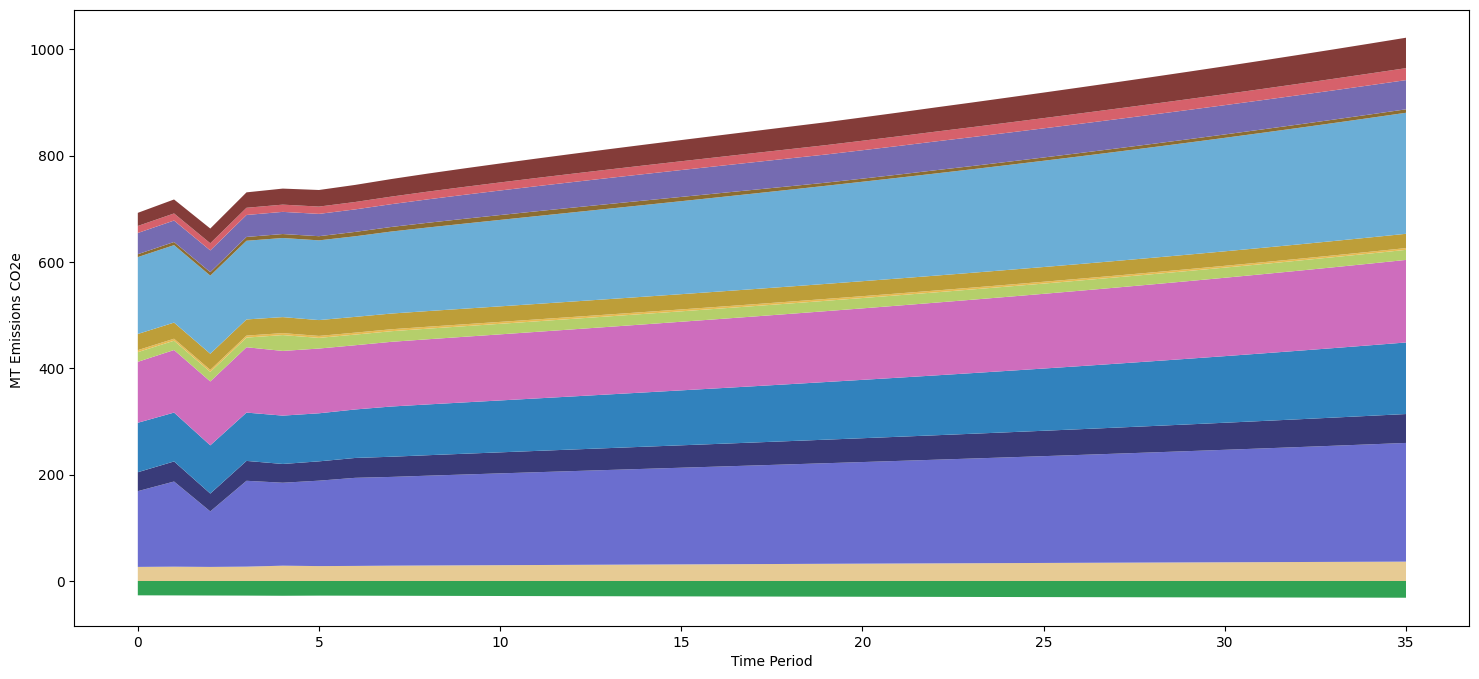

In [1176]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_outputs_new#[
#    df_outputs_new[ssp.key_primary].isin([71071])
#]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



<Axes: >

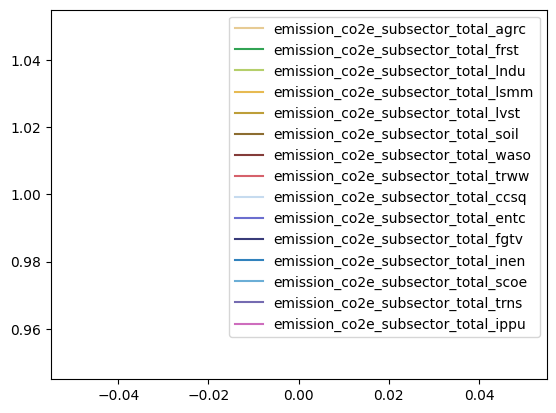

In [1183]:
df_legend = pd.DataFrame(
    dict(
        (k, [1]) for k in matt.get_subsector_color_map().keys()
    )
)
df_legend.plot(color = matt.get_subsector_color_map())

<Axes: >

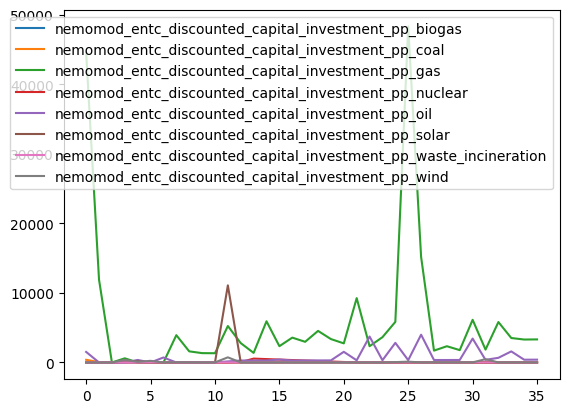

In [1185]:

df_prim = df_outputs_new
df_in_cur = df_inputs_new


fields_plot = [
    x for x in df_prim.columns
    if "investment" in x
    and df_prim[x].max() > 0
]
(
    df_prim[fields_plot]
    .plot(
        legend = True,
    )
)




In [139]:
matt.extract_model_variable(
    df_out_raw,
    "Energy Demand by Fuel in SCOE"#Industrial Energy"
).iloc[7]

energy_demand_enfu_subsector_total_pj_scoe_fuel_biofuels                      0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biogas                        0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_biomass                     546.753417
energy_demand_enfu_subsector_total_pj_scoe_fuel_coal                         78.779258
energy_demand_enfu_subsector_total_pj_scoe_fuel_coke                          0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_crude                         0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_diesel                      662.233684
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity                3556.017787
energy_demand_enfu_subsector_total_pj_scoe_fuel_furnace_gas                   0.000000
energy_demand_enfu_subsector_total_pj_scoe_fuel_gasoline                     82.779210
energy_demand_enfu_subsector_total_pj_scoe_fuel_geothermal                    0.000000
energy_demand_enfu_subsector_total_pj_scoe_

In [131]:
dict_files.keys()

dict_keys(['transport total final consumption by source', 'industry total final consumption by source', 'total final energy consumption', 'commercial and public services total final consumption by source', 'residential total final consumption by source', 'electricity generation sources'])

In [138]:
df = dict_files.get("industry total final consumption by source")
df = dict_files.get("commercial and public services total final consumption by source")
df2 = dict_files.get("residential total final consumption by source")
df[df["Year"].isin([2022])]["Value"].sum()/1000 + df2[df2["Year"].isin([2022])]["Value"].sum()/1000

3258.703

##  Build MSP

In [98]:


"""


df_electricity_generation_share_g = (
    df_electricity_generation_share
    .groupby(["Year", ])
)


data_electricity_generation_share = do.DatasetIEA(
    df_electricity_generation_share
)
"""
build_msp(dict_files)["Fuel"].unique()


#df_electricity_generation_share["Value"] = df_electricity_generation_share["Value"]/df_electricity_generation_share["Value"].sum()
#df_electricity_generation_share

#data_electricity_generation_share.df

array(['Coal', 'Oil', 'Natural gas', 'Nuclear', 'Hydro', 'Biofuels',
       'Wind', 'Solar PV'], dtype=object)

True

In [99]:
matt.get_attribute_table("Energy Technology")

,category_name,cat_technology,description,data_source,hyperlink,notes,operational_life,technology_from_storage,technology_to_storage,electricity_generation_cat_fuel,cat_storage,generates_fuel_cat_fuel,fuel_processing,mining_and_extraction,power_plant,storage,renewable_default
0,Fuel Production - Ammonia,fp_ammonia_production,Ammonia production using the Haber-Bosch proce...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
1,Fuel Production - Hydrogen Electrolysis,fp_hydrogen_electrolysis,"Hydrogen generation from electrolysis, which r...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
2,Fuel Production - Hydrogen from Coal Gasification,fp_hydrogen_gasification,Hydrogen generation from fossil-fuel driven th...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
3,Fuel Production - Hydrogen Steam Methane Refor...,fp_hydrogen_reformation,Hydrogen generation from steam-methane reforma...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
4,Fuel Production - Hydrogen Steam Methane Refor...,fp_hydrogen_reformation_ccs,Hydrogen generation from steam-methane reforma...,NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
5,Fuel Production - Natural Gas,fp_natural_gas,"Natural gas processing, which refines unproces...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
6,Fuel Production - Petroleum Refinement,fp_petroleum_refinement,"Oil refinery technology, which produce inputs ...",NaN,NaN,NaN,100,none,none,none,none,none,1,0,0,0,0
7,Mining and Exploration - Coal,me_coal,Coal mining and extraction; produces ``fuel_co...,NaN,NaN,NaN,100,none,none,none,none,``fuel_coal``,0,1,0,0,0
8,Mining and Exploration - Crude,me_crude,Crude oil exploration and extraction; produces...,NaN,NaN,NaN,100,none,none,none,none,``fuel_crude``,0,1,0,0,0
9,Mining and Exploration - Natural Gas,me_natural_gas,Natural gas exploration and extraction; produc...,NaN,NaN,NaN,100,none,none,none,none,``fuel_natural_gas_unprocessed``,0,1,0,0,0


In [60]:
#df_electricity_generation_share
dir(data_electricity_generation_share)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_initialize_data_frame',
 '_initialize_fields',
 '_initialize_melt_fields',
 '_initialize_reader_specification',
 '_subset',
 'df',
 'dict_field_definition',
 'field_keys',
 'field_units',
 'field_value',
 'field_year',
 'fields',
 'fields_integer',
 'file_read_specification',
 'get_integer_fields',
 'get_subset',
 'melt_by_subset',
 'read']

In [398]:
df_inputs

,time_period,ef_enfu_combustion_tonne_co2_per_tj_fuel_water,ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_water,ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_water,cost_enfu_fuel_ammonia_usd_per_tonne,ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia,ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia,ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia,ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia,exports_enfu_pj_fuel_ammonia,...,va_mining_mmm_usd,va_manufacturing_mmm_usd,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_tonne,demscalar_ippu_recycled_metals,va_industrial_mmm_usd,demscalar_ippu_recycled_textiles,demscalar_ippu_recycled_rubber_and_leather,va_commercial_mmm_usd,demscalar_ippu_recycled_plastic,region
0,0,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,2.954671,6.239061,1530,1,10.648961,1,1,38.831074,1,iran
1,1,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.080127,6.518428,1530,1,10.939956,1,1,40.739526,1,iran
2,2,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.183768,6.936926,1530,1,11.224979,1,1,42.253987,1,iran
3,3,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.266670,7.196583,1530,1,11.809202,1,1,43.092214,1,iran
4,4,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.361589,7.402811,1530,1,12.144927,1,1,44.391061,1,iran
5,5,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.455924,7.607812,1530,1,12.479776,1,1,45.677420,1,iran
6,6,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.560141,7.833482,1530,1,12.849972,1,1,47.091702,1,iran
7,7,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.671422,8.074161,1530,1,13.246047,1,1,48.595983,1,iran
8,8,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.794604,8.340167,1530,1,13.684969,1,1,50.255204,1,iran
9,9,0.0,0.0,0.0,100,0,0.0001,0,0.0001,0,...,3.929847,8.632126,1530,1,14.167676,1,1,52.071246,1,iran
